In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import norm

In [2]:
ALPHA = 0.05    # Level of significance for the confidence intervals
EPSILON = 0.05  # Parameter for estimating confidence interval of a quantile

Read the data

In [3]:
DatOriginal = pd.read_csv("DatasetsMedicalResearch/Time to discontinuation of the use of an IUD.dat", sep="\s+")
DatOriginal = DatOriginal.rename({'time':'Time'}, axis=1)
DatOriginal['Censored'] = (DatOriginal['status']-1)*(-1)
DatOriginal = DatOriginal.drop('status', axis=1)

<>:1: SyntaxWarning: invalid escape sequence '\s'
<>:1: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_6167/2778634000.py:1: SyntaxWarning: invalid escape sequence '\s'
  DatOriginal = pd.read_csv("DatasetsMedicalResearch/Time to discontinuation of the use of an IUD.dat", sep="\s+")


---

Function to create the life-table

In [4]:
def CreateLifeTable(data):

    datalifetable = pd.DataFrame(
        {
            'tj': np.unique([0] + data.loc[data['Censored']==0, 'Time'].sort_values().to_list())
        }
    )

    datalifetable = datalifetable.reset_index(drop=True)

    datalifetable['tj+1'] = datalifetable['tj'].to_list()[1:] + [np.inf]

    n_list, d_list, c_list = [], [], []

    for j in range(len(datalifetable)):
        
        if j==0:
            n = len(data)
        else:
            n = n-d-c

        d = sum(data.loc[data['Censored']==0, 'Time'] == datalifetable.loc[j]['tj'])
        c = sum(
                (data.loc[data['Censored']==1, 'Time'] >= datalifetable.loc[j]['tj']) 
                & (data.loc[data['Censored']==1, 'Time'] < datalifetable.loc[j]['tj+1'])
            )

        n_list.append(n)
        d_list.append(d)
        c_list.append(c)

    datalifetable['nj'] = n_list
    datalifetable['dj'] = d_list
    datalifetable['cj'] = c_list

    return datalifetable

Function to calculate the survivor function, cumulative hazard function, and hazard function using the Kaplan-Meier approach

In [5]:
def KaplanMeier(datalifetable):
    datakm = datalifetable.copy()

    # Estimate survivor function, cumulative hazard function and hazard function
    datakm['Survivor'] = np.cumprod((datakm['nj'] - datakm['dj']) / datakm['nj'])
    datakm['CumHazard'] = -np.log(datakm['Survivor'])
    datakm['Hazard'] = datakm['dj'] / (datakm['nj'] * (datakm['tj+1'] - datakm['tj']))

    # Estimate standard deviation of the cumulative hazard function, and survivor function
    datakm['StdCumHazard'] = np.sqrt(np.cumsum(datakm['dj'] / (datakm['nj'] * (datakm['nj'] - datakm['dj']))))
    datakm['StdSurvivor'] = datakm['Survivor'] * datakm['StdCumHazard']

    return datakm

Function to calculate the survivor function, cumulative hazard function, and hazard function using the Kaplan-Meier approach

In [6]:
def NelsonAalen(datalifetable):
    datana = datalifetable.copy()

    # Estimate survivor function, cumulative hazard function and hazard function
    datana['CumHazard'] = np.cumsum(datana['dj'] / datana['nj'])
    datana['Survivor'] = np.exp(-datana['CumHazard'])
    datana['Hazard'] = datana['dj'] / (datana['nj'] * (datana['tj+1'] - datana['tj']))

    # Estimate standard deviation of the cumulative hazard function, and survivor function
    datana['StdCumHazard'] = np.sqrt(np.cumsum(datana['dj'] / datana['nj']**2))
    datana['StdSurvivor'] = datana['Survivor'] * datana['StdCumHazard']

    return datana

Function to compute confidence intervals for the cumulative hazard function, and the survivor function

In [7]:
def GetConfidenceInterval(datasurvivor, alpha):

    datasurvivor['LowerLogCumHazar'] = norm.ppf(alpha/2, np.log(datasurvivor['CumHazard']), datasurvivor['StdCumHazard'] / datasurvivor['CumHazard'])
    datasurvivor['UpperLogCumHazar'] = norm.ppf(1-alpha/2, np.log(datasurvivor['CumHazard']), datasurvivor['StdCumHazard'] / datasurvivor['CumHazard'])

    datasurvivor['LowerCumHazard'] = np.exp(datasurvivor['LowerLogCumHazar'])
    datasurvivor['UpperCumHazard'] = np.exp(datasurvivor['UpperLogCumHazar'])

    datasurvivor['LowerSurvivor'] = np.exp(-datasurvivor['UpperCumHazard'])
    datasurvivor['UpperSurvivor'] = np.exp(-datasurvivor['LowerCumHazard'])
    
    datasurvivor = datasurvivor.drop(['LowerLogCumHazar', 'UpperLogCumHazar'], axis=1)
    
    return datasurvivor

Function to estimate the quantile of probability $p$

In [8]:
def InferenceQuantile(p, alpha, epsilon, datasurvivor):
    
    #Estimating the quantile of probability $p$
    tp = min(datasurvivor.loc[datasurvivor['Survivor']<p, 'tj'].to_list())

    #Estimate the standard deviation of the quantile
    u = max(datasurvivor.loc[datasurvivor['Survivor']>=1-p+epsilon, 'tj'].to_list())
    l = min(datasurvivor.loc[datasurvivor['Survivor']<=1-p-epsilon, 'tj'].to_list())

    if u == l:
        raise ValueError("u and l equal, try to increase the value of epsilon")
    else:
        f_tp = (datasurvivor.loc[datasurvivor['tj'] == u, 'Survivor'].to_list()[0] - datasurvivor.loc[datasurvivor['tj'] == l, 'Survivor'].to_list()[0]) / (l - u)

    Std_tp = datasurvivor.loc[datasurvivor['tj'] == tp, 'StdSurvivor'].to_list()[0] / f_tp

    return pd.DataFrame({'Prob.':p, 'Quantile':tp, 'LowerQuantile':norm.ppf(alpha/2, tp, Std_tp), 'UpperQuantile':norm.ppf(1-alpha/2, tp, Std_tp)}, index=[0])

---

In [9]:
DatOriginal

,Time,Censored
0,10,0
1,13,1
2,18,1
3,19,0
4,23,1
5,30,0
6,36,0
7,38,1
8,54,1
9,56,1


Create the life-table

In [10]:
DatLifeTable = CreateLifeTable(DatOriginal)

In [11]:
DatLifeTable

,tj,tj+1,nj,dj,cj
0,0,10.0,18,0,0
1,10,19.0,18,1,2
2,19,30.0,15,1,1
3,30,36.0,13,1,0
4,36,59.0,12,1,3
5,59,75.0,8,1,0
6,75,93.0,7,1,0
7,93,97.0,6,1,0
8,97,107.0,5,1,1
9,107,inf,3,1,2


Get the Kaplan-Meier and the Nelson-Aalen estimators

In [12]:
DatKaplanMeier = KaplanMeier(DatLifeTable)
DatKaplanMeier = GetConfidenceInterval(DatKaplanMeier, ALPHA)

DatNelsonAalen = NelsonAalen(DatLifeTable)
DatNelsonAalen = GetConfidenceInterval(DatNelsonAalen, ALPHA)

/home/dmitri/.local/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/dmitri/.local/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/dmitri/.local/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/dmitri/.local/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [13]:
DatKaplanMeier.round(4)

,tj,tj+1,nj,dj,cj,Survivor,CumHazard,Hazard,StdCumHazard,StdSurvivor,LowerCumHazard,UpperCumHazard,LowerSurvivor,UpperSurvivor
0,0,10.0,18,0,0,1.0000,-0.0000,0.0000,0.0000,0.0000,NaN,NaN,NaN,NaN
1,10,19.0,18,1,2,0.9444,0.0572,0.0062,0.0572,0.0540,0.0080,0.4059,0.6664,0.9920
2,19,30.0,15,1,1,0.8815,0.1262,0.0061,0.0896,0.0790,0.0314,0.5076,0.6019,0.9691
3,30,36.0,13,1,0,0.8137,0.2062,0.0128,0.1202,0.0978,0.0658,0.6462,0.5241,0.9363
4,36,59.0,12,1,3,0.7459,0.2932,0.0036,0.1484,0.1107,0.1087,0.7905,0.4536,0.8970
5,59,75.0,8,1,0,0.6526,0.4267,0.0078,0.1997,0.1303,0.1706,1.0677,0.3438,0.8432
6,75,93.0,7,1,0,0.5594,0.5809,0.0079,0.2524,0.1412,0.2479,1.3611,0.2564,0.7804
7,93,97.0,6,1,0,0.4662,0.7632,0.0417,0.3115,0.1452,0.3430,1.6984,0.1830,0.7097
8,97,107.0,5,1,1,0.3729,0.9864,0.0200,0.3834,0.1430,0.4604,2.1131,0.1209,0.6310
9,107,inf,3,1,2,0.2486,1.3918,0.0000,0.5601,0.1392,0.6325,3.0627,0.0468,0.5313


In [14]:
DatNelsonAalen.round(4)

,tj,tj+1,nj,dj,cj,CumHazard,Survivor,Hazard,StdCumHazard,StdSurvivor,LowerCumHazard,UpperCumHazard,LowerSurvivor,UpperSurvivor
0,0,10.0,18,0,0,0.0000,1.0000,0.0000,0.0000,0.0000,NaN,NaN,NaN,NaN
1,10,19.0,18,1,2,0.0556,0.9460,0.0062,0.0556,0.0526,0.0078,0.3944,0.6741,0.9922
2,19,30.0,15,1,1,0.1222,0.8850,0.0061,0.0868,0.0768,0.0304,0.4915,0.6117,0.9701
3,30,36.0,13,1,0,0.1991,0.8194,0.0128,0.1160,0.0950,0.0636,0.6235,0.5361,0.9384
4,36,59.0,12,1,3,0.2825,0.7539,0.0036,0.1428,0.1077,0.1049,0.7608,0.4673,0.9004
5,59,75.0,8,1,0,0.4075,0.6653,0.0078,0.1898,0.1263,0.1636,1.0152,0.3623,0.8491
6,75,93.0,7,1,0,0.5503,0.5768,0.0079,0.2375,0.1370,0.2362,1.2824,0.2774,0.7896
7,93,97.0,6,1,0,0.7170,0.4882,0.0417,0.2902,0.1417,0.3244,1.5849,0.2050,0.7230
8,97,107.0,5,1,1,0.9170,0.3997,0.0200,0.3524,0.1409,0.4318,1.9476,0.1426,0.6494
9,107,inf,3,1,2,1.2503,0.2864,0.0000,0.4851,0.1389,0.5845,2.6747,0.0689,0.5574


Plot the survivor estimators

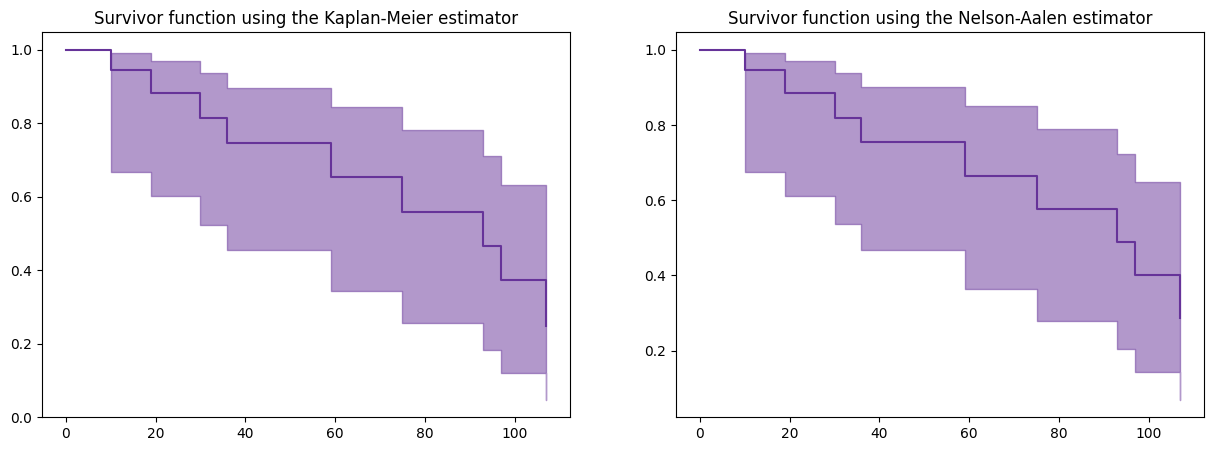

In [15]:
f, ax = plt.subplots(1, 2, figsize=(15,5), sharex=True) # The subfigures share the same x axis

ax[0].fill_between(DatKaplanMeier['tj'], DatKaplanMeier['LowerSurvivor'], DatKaplanMeier['UpperSurvivor'], step='post', alpha=0.5, color='rebeccapurple')
ax[0].step(DatKaplanMeier['tj'], DatKaplanMeier['Survivor'], where='post', color='rebeccapurple')
_ = ax[0].set_title("Survivor function using the Kaplan-Meier estimator")

ax[1].fill_between(DatNelsonAalen['tj'], DatNelsonAalen['LowerSurvivor'], DatNelsonAalen['UpperSurvivor'], step='post', alpha=0.5, color='rebeccapurple')
ax[1].step(DatNelsonAalen['tj'], DatNelsonAalen['Survivor'], where='post', color='rebeccapurple')
_ = ax[1].set_title("Survivor function using the Nelson-Aalen estimator")

Plot the estimated hazard function

Text(0.5, 1.0, 'Estimated hazard function')

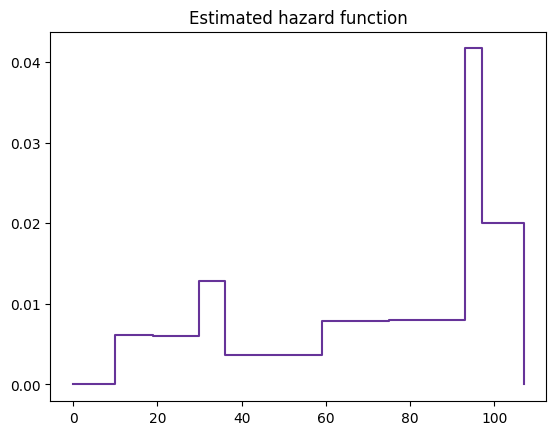

In [16]:
plt.step(DatKaplanMeier['tj'], DatKaplanMeier['Hazard'], where='post', color='rebeccapurple')
plt.title("Estimated hazard function")

Quantile inference

In [17]:
InferenceQuantile(0.5, ALPHA, EPSILON, DatKaplanMeier)

,Prob.,Quantile,LowerQuantile,UpperQuantile
0,0.5,93,59.423747,126.576253


In [18]:
InferenceQuantile(0.5, ALPHA, EPSILON, DatNelsonAalen)

,Prob.,Quantile,LowerQuantile,UpperQuantile
0,0.5,93,58.495774,127.504226
